PCA-BASED REP COUNTER

[Step 1] Applying PCA...
  Explained variance:
    PC1: 77.6%
    PC2: 14.5%
    PC3: 7.9%
  → PC1 captures 77.6% of motion

[Step 1.5] Smoothing PC1 signal...
  Window length: 31
  Polynomial order: 3

[Step 2] Detecting peaks...
  Signal std: 20.70
  Prominence threshold: 12.42
  Min distance: 30 samples

[Result] 4 reps detected
  Peak locations (samples): [230 292 367 427]

Plot saved to: rep_analysis_improved.png

✓ FINAL COUNT: 4 REPS


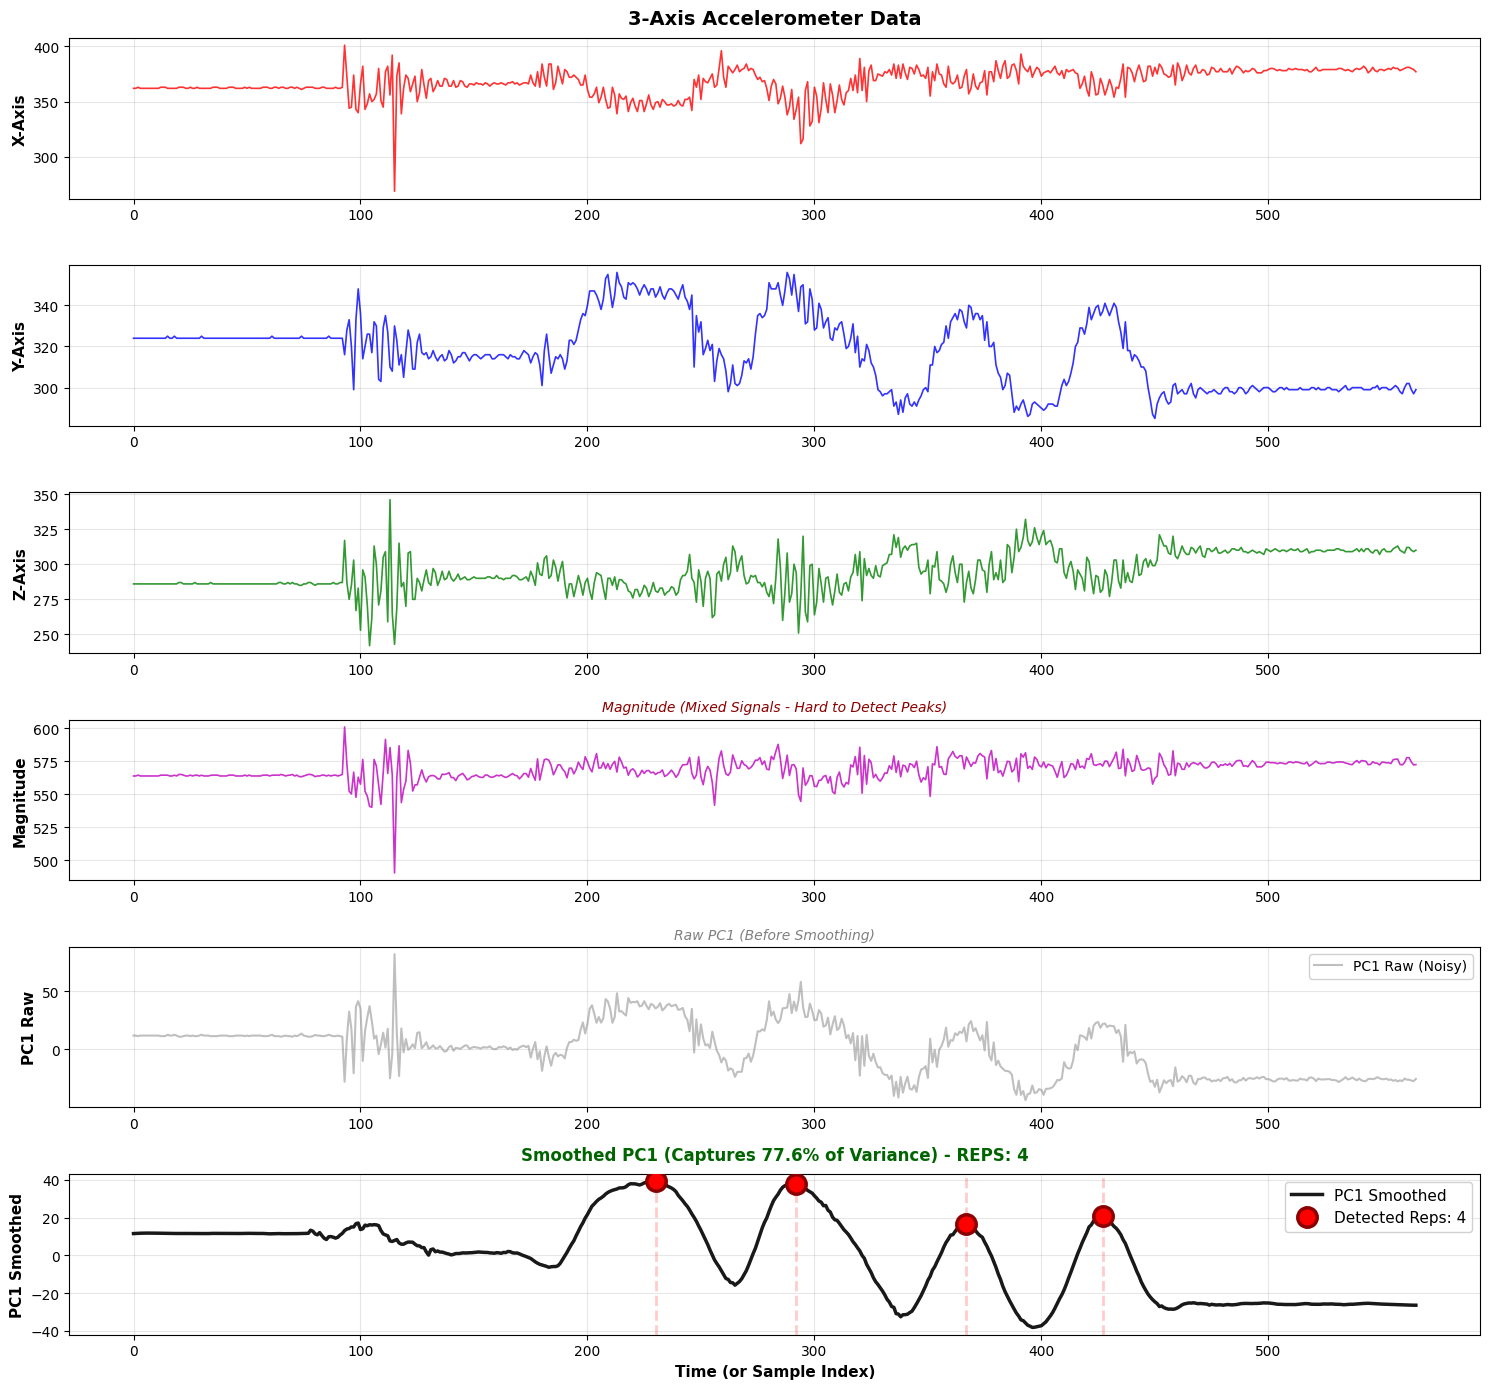

In [ ]:
"""
PCA-Based Rep Counter for Exercise Tracking
============================================

This module provides an exercise-agnostic rep counter using PCA to find
the direction of maximum variance in 3-axis accelerometer data.

"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.signal import find_peaks, savgol_filter


class RepCounter:
    """
    Exercise-agnostic rep counter using PCA and peak detection.
    """

    def __init__(self, prominence_factor=0.7, min_distance_samples=120,
                 use_valleys=True, smooth_window=21, smooth_polyorder=3):
        """
        Initialize the rep counter.

        Parameters:
        -----------
        prominence_factor : float (default=0.7)
            Multiplier for signal std dev to set peak prominence.
            Higher = stricter (fewer false positives)
            Lower = more sensitive (may catch noise)
            Typical range: 0.5 - 1.2

        min_distance_samples : int (default=120)
            Minimum samples between consecutive reps.
            Prevents double-counting the same rep.
            Depends on your sampling rate and exercise speed.
            Example: 100 Hz sampling, ~1 rep/sec → 100-150 samples

        use_valleys : bool (default=True)
            If True, detect valleys (negative peaks) instead of peaks.
            Sometimes the down-motion is cleaner than up-motion.

        smooth_window : int (default=21)
            Window length for Savitzky-Golay smoothing filter.
            Must be odd. Larger = more smoothing.
            Typical range: 11-51

        smooth_polyorder : int (default=3)
            Polynomial order for Savitzky-Golay filter.
            Must be less than smooth_window.
            Typical: 2-4
        """
        self.prominence_factor = prominence_factor
        self.min_distance_samples = min_distance_samples
        self.use_valleys = use_valleys
        self.smooth_window = smooth_window
        self.smooth_polyorder = smooth_polyorder

    def count_reps(self, data, verbose=True):
        """
        Count reps in the accelerometer data.

        Parameters:
        -----------
        data : np.ndarray
            Shape (n_samples, 3) containing [x, y, z] accelerometer readings

        verbose : bool
            Print detailed information during processing

        Returns:
        --------
        results : dict
            {
                'num_reps': int,
                'peak_indices': np.ndarray,
                'pc1_signal': np.ndarray,
                'pc1_smoothed': np.ndarray,
                'pca': PCA object,
                'explained_variance': list of floats
            }
        """
        if verbose:
            print("=" * 70)
            print("PCA-BASED REP COUNTER")
            print("=" * 70)

        # Step 1: Apply PCA to find direction of maximum variance
        if verbose:
            print("\n[Step 1] Applying PCA...")

        pca = PCA(n_components=3)
        pca_transformed = pca.fit_transform(data)
        pc1_signal = pca_transformed[:, 0]

        explained_var = pca.explained_variance_ratio_

        if verbose:
            print(f"  Explained variance:")
            for i, var in enumerate(explained_var):
                print(f"    PC{i+1}: {var*100:.1f}%")
            print(f"  → PC1 captures {explained_var[0]*100:.1f}% of motion")

        # Step 1.5: Smooth the PC1 signal to remove high-frequency noise
        if verbose:
            print(f"\n[Step 1.5] Smoothing PC1 signal...")
            print(f"  Window length: {self.smooth_window}")
            print(f"  Polynomial order: {self.smooth_polyorder}")

        pc1_smoothed = savgol_filter(pc1_signal,
                                     window_length=self.smooth_window,
                                     polyorder=self.smooth_polyorder)

        # Step 2: Detect peaks in smoothed PC1
        if verbose:
            print(f"\n[Step 2] Detecting {'valleys' if self.use_valleys else 'peaks'}...")

        signal_std = np.std(pc1_smoothed)
        prominence = self.prominence_factor * signal_std

        if verbose:
            print(f"  Signal std: {signal_std:.2f}")
            print(f"  Prominence threshold: {prominence:.2f}")
            print(f"  Min distance: {self.min_distance_samples} samples")

        # Find peaks or valleys in SMOOTHED signal
        if self.use_valleys:
            peak_indices, properties = find_peaks(-pc1_smoothed,
                                                    prominence=prominence,
                                                    distance=self.min_distance_samples)
        else:
            peak_indices, properties = find_peaks(pc1_smoothed,
                                                   prominence=prominence,
                                                   distance=self.min_distance_samples)

        num_reps = len(peak_indices)

        if verbose:
            print(f"\n[Result] {num_reps} reps detected")
            if num_reps > 0:
                print(f"  Peak locations (samples): {peak_indices}")

        return {
            'num_reps': num_reps,
            'peak_indices': peak_indices,
            'pc1_signal': pc1_signal,
            'pc1_smoothed': pc1_smoothed,
            'pca': pca,
            'explained_variance': explained_var,
            'properties': properties
        }

    def plot_results(self, data, results, time=None, save_path=None):
        """
        Create visualization of the analysis.

        Parameters:
        -----------
        data : np.ndarray
            Original accelerometer data
        results : dict
            Output from count_reps()
        time : np.ndarray, optional
            Time vector for x-axis
        save_path : str, optional
            Path to save figure
        """
        n_samples = len(data)
        if time is None:
            time = np.arange(n_samples)

        pc1_signal = results['pc1_signal']
        pc1_smoothed = results['pc1_smoothed']
        peak_indices = results['peak_indices']
        num_reps = results['num_reps']

        # Calculate magnitude for comparison
        magnitude = np.linalg.norm(data, axis=1)

        # Create figure
        fig, axes = plt.subplots(6, 1, figsize=(15, 14))

        # X-axis
        axes[0].plot(time, data[:, 0], 'r-', linewidth=1.2, alpha=0.8)
        axes[0].set_ylabel('X-Axis', fontsize=11, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        axes[0].set_title('3-Axis Accelerometer Data',
                         fontsize=14, fontweight='bold', pad=10)

        # Y-axis
        axes[1].plot(time, data[:, 1], 'b-', linewidth=1.2, alpha=0.8)
        axes[1].set_ylabel('Y-Axis', fontsize=11, fontweight='bold')
        axes[1].grid(True, alpha=0.3)

        # Z-axis
        axes[2].plot(time, data[:, 2], 'g-', linewidth=1.2, alpha=0.8)
        axes[2].set_ylabel('Z-Axis', fontsize=11, fontweight='bold')
        axes[2].grid(True, alpha=0.3)

        # Magnitude (showing why it doesn't work well)
        axes[3].plot(time, magnitude, 'm-', linewidth=1.2, alpha=0.8)
        axes[3].set_ylabel('Magnitude', fontsize=11, fontweight='bold')
        axes[3].grid(True, alpha=0.3)
        axes[3].set_title('Magnitude (Mixed Signals - Hard to Detect Peaks)',
                         fontsize=10, style='italic', color='darkred')

        # PC1 raw (noisy)
        axes[4].plot(time, pc1_signal, 'gray', linewidth=1.5, alpha=0.5,
                    label='PC1 Raw (Noisy)', linestyle='-')
        axes[4].set_ylabel('PC1 Raw', fontsize=11, fontweight='bold')
        axes[4].grid(True, alpha=0.3)
        axes[4].legend(loc='upper right', fontsize=10, framealpha=0.9)
        axes[4].set_title('Raw PC1 (Before Smoothing)',
                         fontsize=10, style='italic', color='gray')

        # PC1 smoothed with detected peaks
        axes[5].plot(time, pc1_smoothed, 'k-', linewidth=2.5,
                    label='PC1 Smoothed', alpha=0.9)

        if num_reps > 0:
            axes[5].plot(time[peak_indices], pc1_smoothed[peak_indices],
                        'ro', markersize=14, markeredgewidth=2.5,
                        markeredgecolor='darkred', markerfacecolor='red',
                        label=f'Detected Reps: {num_reps}', zorder=5)

            # Add vertical lines at peaks for clarity
            for peak_idx in peak_indices:
                axes[5].axvline(time[peak_idx], color='red',
                              alpha=0.2, linewidth=2, linestyle='--')

        axes[5].set_ylabel('PC1 Smoothed', fontsize=11, fontweight='bold')
        axes[5].set_xlabel('Time (or Sample Index)', fontsize=11, fontweight='bold')
        axes[5].grid(True, alpha=0.3)
        axes[5].legend(loc='upper right', fontsize=11, framealpha=0.9)

        var_pct = results['explained_variance'][0] * 100
        axes[5].set_title(f'Smoothed PC1 (Captures {var_pct:.1f}% of Variance) - REPS: {num_reps}',
                         fontsize=12, fontweight='bold', color='darkgreen', pad=10)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"\nPlot saved to: {save_path}")

        return fig


# Example usage
if __name__ == "__main__":
    # Load or generate your accelerometer data
    # For this example, we'll create synthetic data with 4 clear reps
    # Read the data
    data = []
    with open('imu_data.txt', 'r') as f:
        for line in f:
            values = line.strip().split()
            if len(values) == 3:
                data.append([int(v) for v in values])

    data = np.array(data)

    # Extract each axis
    x_axis = data[:, 0]
    y_axis = data[:, 1]
    z_axis = data[:, 2]

    data = np.column_stack([x_axis, y_axis, z_axis])

    # Create rep counter with smoothing parameters tuned for your data
    counter = RepCounter(
        prominence_factor=0.6,      # Lower for more sensitivity to the 4 big peaks
        min_distance_samples=30,    # Slightly lower to catch peaks closer together
        use_valleys=False,           # Keep this since valleys look cleaner
        smooth_window=31,           # Increase smoothing to remove noise
        smooth_polyorder=3          # Keep polynomial order reasonable
    )

    results = counter.count_reps(data, verbose=True)

    # Visualize
    counter.plot_results(data, results,
                        save_path='rep_analysis_improved.png')

    print("\n" + "=" * 70)
    print(f"✓ FINAL COUNT: {results['num_reps']} REPS")
    print("=" * 70)